In [1]:
# Bu notebook baseline_ovr_logreg (siz train qilgan) natijasini chuqur tahlil qiladi:

# Testda qayerlarda xato bo‘lyapti (FP/FN)

# Qaysi label yomon (support, F1)

# Probabilistik ishonchlilik (calibration/reliability)

# Text uzunligi / label soni bo‘yicha performance slice

# LogisticRegression koefflari orqali top feature (word qismi) — interpretatsiya

# Natijalarni results/tables/advanced_eda_outputs/ va visuals/advanced_EDA/ ga saqlaydi



#CELL 1 — Imports + Paths

from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import joblib

from sklearn.metrics import f1_score, precision_score, recall_score

# --- Project root ---
CWD = Path.cwd()
if (CWD / "Data").exists():
    PROJECT_ROOT = CWD
elif (CWD.parent / "Data").exists():
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

# --- Split folder (sizdagi nom) ---
SPLIT_DIR = PROJECT_ROOT / "Data" / "Processed" / "splits_multilabel_noleakage"

# --- Preprocess folder (05 natijasi) ---
PP_DIR = PROJECT_ROOT / "Data" / "Preprocessed_data" / "baseline"

# --- Model folder (06 natijasi) ---
MODEL_DIR = PROJECT_ROOT / "Models" / "baseline_models"

# --- Outputs ---
TABLES_OUT = PROJECT_ROOT / "results" / "tables" / "advanced_eda_outputs"
VIS_OUT    = PROJECT_ROOT / "visuals" / "improvement_EDA"
TABLES_OUT.mkdir(parents=True, exist_ok=True)
VIS_OUT.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SPLIT_DIR:", SPLIT_DIR, "exists:", SPLIT_DIR.exists())
print("PP_DIR   :", PP_DIR, "exists:", PP_DIR.exists())
print("MODEL_DIR:", MODEL_DIR, "exists:", MODEL_DIR.exists())
print("TABLES_OUT:", TABLES_OUT)
print("VIS_OUT   :", VIS_OUT)

PROJECT_ROOT: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract
SPLIT_DIR: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\Data\Processed\splits_multilabel_noleakage exists: True
PP_DIR   : c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\Data\Preprocessed_data\baseline exists: True
MODEL_DIR: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\Models\baseline_models exists: True
TABLES_OUT: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\results\tables\advanced_eda_outputs
VIS_OUT   : c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\visuals\improvement_EDA


In [2]:
# CELL 2 — Load test/val raw text + X/Y + model + thresholds + labels
TEXT_COL = "REAC_pt_symptom_v2"

# raw (text) – test + val (calibration check uchun)
df_test = pd.read_csv(SPLIT_DIR / "test.csv", low_memory=False)
df_val  = pd.read_csv(SPLIT_DIR / "val.csv",  low_memory=False)

# X/Y – preprocessdan
Xte = sparse.load_npz(PP_DIR / "X_test.npz")
Yte = np.load(PP_DIR / "Y_test.npy")

Xva = sparse.load_npz(PP_DIR / "X_val.npz")
Yva = np.load(PP_DIR / "Y_val.npy")

# bundle (labels + vectorizers)
bundle = joblib.load(PP_DIR / "tfidf_bundle.joblib")
y_cols = list(bundle["y_cols"])

# model + thresholds
model = joblib.load(MODEL_DIR / "baseline_ovr_logreg.joblib")
thr   = np.load(MODEL_DIR / "baseline_ovr_logreg_thresholds.npy") if (MODEL_DIR / "baseline_ovr_logreg_thresholds.npy").exists() else np.load(MODEL_DIR / "thresholds.npy")

print("df_test shape:", df_test.shape)
print("Xte/Yte:", Xte.shape, Yte.shape)
print("Num labels:", len(y_cols))
print("Thresholds shape:", thr.shape)

# sanity
assert TEXT_COL in df_test.columns, f"Missing TEXT_COL: {TEXT_COL}"

df_test shape: (24164, 24)
Xte/Yte: (24164, 58921) (24164, 21)
Num labels: 21
Thresholds shape: (21,)


In [3]:
# CELL 3 — Predict probs + apply thresholds + overall metrics (TEST)

Pte = model.predict_proba(Xte)
Ypred = (Pte >= thr.reshape(1, -1)).astype(int)

metrics = {
    "micro_f1": float(f1_score(Yte, Ypred, average="micro", zero_division=0)),
    "macro_f1": float(f1_score(Yte, Ypred, average="macro", zero_division=0)),
    "micro_precision": float(precision_score(Yte, Ypred, average="micro", zero_division=0)),
    "micro_recall": float(recall_score(Yte, Ypred, average="micro", zero_division=0)),
}
print("TEST metrics:", metrics)

# Save summary
(TABLES_OUT / "test_overall_metrics.json").write_text(json.dumps(metrics, indent=2, ensure_ascii=False), encoding="utf-8")

TEST metrics: {'micro_f1': 0.9973343085080789, 'macro_f1': 0.9958330355582568, 'micro_precision': 0.9960402890973397, 'micro_recall': 0.9986316945788125}


149

In [4]:
# CELL 4 — Per-label metrics + save
rows = []
for j, col in enumerate(y_cols):
    name = col.replace("y_", "", 1)
    yj = Yte[:, j]
    pj = Ypred[:, j]
    rows.append({
        "label": name,
        "support": int(yj.sum()),
        "precision": float(precision_score(yj, pj, zero_division=0)),
        "recall": float(recall_score(yj, pj, zero_division=0)),
        "f1": float(f1_score(yj, pj, zero_division=0)),
        "threshold": float(thr[j]),
        "pred_pos_rate_%": float(pj.mean() * 100),
    })

per_label_df = pd.DataFrame(rows).sort_values("f1", ascending=True).reset_index(drop=True)
display(per_label_df.head(10))   # eng yomon 10
display(per_label_df.tail(10))   # eng yaxshi 10

per_label_df.to_csv(TABLES_OUT / "test_per_label_metrics.csv", index=False, encoding="utf-8-sig")

,label,support,precision,recall,f1,threshold,pred_pos_rate_%
0,pregnancy_reproductive,154,0.980645,0.987013,0.983819,0.65,0.641450
1,hepatic,816,0.979469,0.993873,0.986618,0.75,3.426585
2,urinary,698,0.987143,0.989971,0.988555,0.80,2.896871
3,ocular_visual,1660,0.988657,0.997590,0.993103,0.65,6.931799
4,renal,982,0.989919,1.000000,0.994934,0.65,4.105281
5,metabolic_endocrine,1384,0.992806,0.997110,0.994953,0.80,5.752359
6,respiratory,2815,0.993284,0.998224,0.995748,0.65,11.707499
7,cardiovascular,3036,0.993124,0.999012,0.996059,0.70,12.638636
8,hematologic,3404,0.993867,0.999706,0.996778,0.65,14.169839
9,gastrointestinal,4912,0.996949,0.997964,0.997457,0.60,20.348452


,label,support,precision,recall,f1,threshold,pred_pos_rate_%
11,neurological,4084,0.996581,0.999265,0.997922,0.60,16.946698
12,dermatologic,5373,0.997212,0.998697,0.997954,0.55,22.268664
13,injection_site,1737,0.996556,0.999424,0.997988,0.75,7.209071
14,hypersensitivity_allergy,1964,0.997965,0.998982,0.998473,0.80,8.136070
15,psychiatric,1735,1.000000,0.997118,0.998557,0.80,7.159411
16,infections,3204,0.998440,0.999064,0.998752,0.70,13.267671
17,injury_accident,1875,0.998933,0.998933,0.998933,0.70,7.759477
18,general_systemic,4077,0.998775,0.999509,0.999142,0.65,16.884622
19,pain_general,4196,0.998810,0.999762,0.999285,0.60,17.381228
20,edema_swelling,1790,0.999442,1.000000,0.999721,0.60,7.411852


In [5]:
# CELL 5 — Error table: worst labels uchun FP/FN top misollar (saqlanadi)
def top_errors_for_label(label_idx, top_k=30):
    lab = y_cols[label_idx].replace("y_", "", 1)
    y_true = Yte[:, label_idx]
    y_hat  = Ypred[:, label_idx]
    p      = Pte[:, label_idx]

    # False Positives: pred=1, true=0, high prob
    fp_mask = (y_hat == 1) & (y_true == 0)
    fp_idx = np.where(fp_mask)[0]
    fp_sorted = fp_idx[np.argsort(-p[fp_idx])] if len(fp_idx) else np.array([], dtype=int)

    # False Negatives: pred=0, true=1, low prob
    fn_mask = (y_hat == 0) & (y_true == 1)
    fn_idx = np.where(fn_mask)[0]
    fn_sorted = fn_idx[np.argsort(p[fn_idx])] if len(fn_idx) else np.array([], dtype=int)

    def build_df(idxs, kind):
        take = idxs[:top_k]
        out = pd.DataFrame({
            "error_type": kind,
            "row_idx": take,
            "prob": p[take],
            "text": df_test.iloc[take][TEXT_COL].astype(str).values,
        })
        out.insert(0, "label", lab)
        return out

    fp_df = build_df(fp_sorted, "FP_high_prob") if len(fp_sorted) else pd.DataFrame(columns=["label","error_type","row_idx","prob","text"])
    fn_df = build_df(fn_sorted, "FN_low_prob")  if len(fn_sorted) else pd.DataFrame(columns=["label","error_type","row_idx","prob","text"])
    return pd.concat([fp_df, fn_df], axis=0, ignore_index=True)


# Eng yomon 5 label (F1 past)
worst5 = per_label_df.head(5)["label"].tolist()
worst5_idx = [ [c.replace("y_","",1) for c in y_cols].index(w) for w in worst5 ]

err_all = []
for idx in worst5_idx:
    err_all.append(top_errors_for_label(idx, top_k=25))

err_df = pd.concat(err_all, axis=0, ignore_index=True)
display(err_df.head(30))

err_df.to_csv(TABLES_OUT / "worst5_labels_fp_fn_examples.csv", index=False, encoding="utf-8-sig")

,label,error_type,row_idx,prob,text
0,pregnancy_reproductive,FP_high_prob,20826,0.961466,Neonatal hyponatraemia; Neonatal respiratory d...
1,pregnancy_reproductive,FP_high_prob,16722,0.828939,Dysmenorrhoea; Menstrual discomfort
2,pregnancy_reproductive,FP_high_prob,17947,0.790888,Renal vein thrombosis; Infection; Renal failur...
3,pregnancy_reproductive,FN_low_prob,3055,0.430159,Physical deconditioning; Thyroid function test...
4,pregnancy_reproductive,FN_low_prob,566,0.492437,Cardiac disorder; Back pain; Pneumonia; Chest ...
5,hepatic,FP_high_prob,13470,0.999888,Diabetes mellitus; Hepatic enzyme decreased
6,hepatic,FP_high_prob,8535,0.983365,Red cell distribution width increased; Tinnitu...
7,hepatic,FP_high_prob,17900,0.981125,Pruritus; Alanine aminotransferase abnormal; B...
8,hepatic,FP_high_prob,15542,0.965509,Blood cholesterol increased; Alanine aminotran...
9,hepatic,FP_high_prob,17169,0.949277,Metastases to liver; Hepatic failure; Weight i...


,token_bin,rows,micro_f1,macro_f1,avg_labels_true,avg_labels_pred
0,"(0, 1]",4356,0.999885,0.236808,1.000000,0.999770
1,"(1, 2]",3906,0.999560,0.952282,1.162570,1.163594
3,"(3, 5]",3771,0.998106,0.996677,1.816494,1.823389
4,"(5, 8]",3713,0.998674,0.998166,2.231619,2.236466
2,"(2, 3]",2796,0.999034,0.994742,1.479256,1.482117
5,"(8, 12]",2420,0.997724,0.996688,2.811983,2.815702
6,"(12, 20]",1798,0.997552,0.995541,3.863181,3.862069
7,"(20, 999]",1404,0.992454,0.989439,7.100427,7.152422


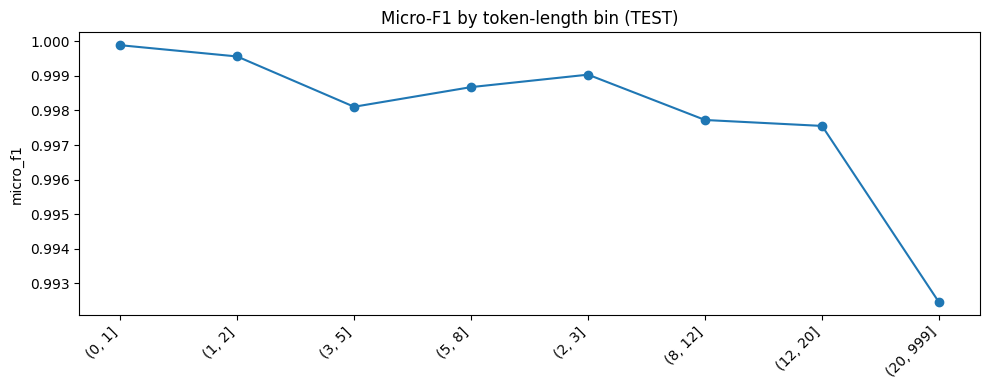

In [6]:
# CELL 6 — Slice analysis: text length bins (qayerda yomonlashadi?)
# text length (tokens) – test
tok_len = df_test[TEXT_COL].fillna("").astype(str).str.split().apply(len)
bins = pd.cut(tok_len, bins=[0,1,2,3,5,8,12,20,999], right=True)

slice_rows = []
for b in bins.unique().sort_values():
    mask = (bins == b).values
    if mask.sum() < 200:
        continue
    Yt = Yte[mask]
    Yp = Ypred[mask]
    slice_rows.append({
        "token_bin": str(b),
        "rows": int(mask.sum()),
        "micro_f1": float(f1_score(Yt, Yp, average="micro", zero_division=0)),
        "macro_f1": float(f1_score(Yt, Yp, average="macro", zero_division=0)),
        "avg_labels_true": float(Yt.sum(axis=1).mean()),
        "avg_labels_pred": float(Yp.sum(axis=1).mean()),
    })

slice_df = pd.DataFrame(slice_rows).sort_values("rows", ascending=False)
display(slice_df)

slice_df.to_csv(TABLES_OUT / "slice_by_token_length.csv", index=False, encoding="utf-8-sig")

# Plot
plt.figure(figsize=(10,4))
plt.plot(slice_df["token_bin"], slice_df["micro_f1"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Micro-F1 by token-length bin (TEST)")
plt.ylabel("micro_f1")
plt.tight_layout()
plt.savefig(VIS_OUT / "slice_micro_f1_by_token_bin.png", dpi=220, bbox_inches="tight")
plt.show()

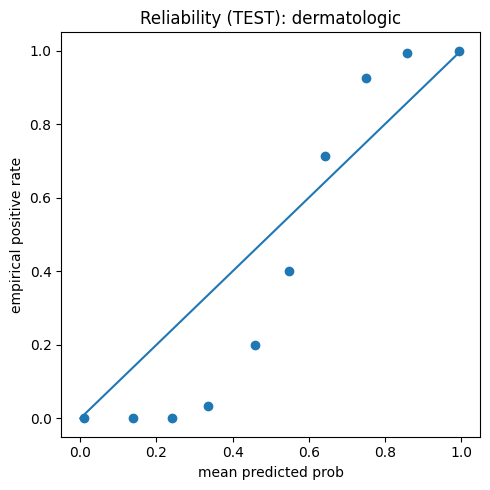

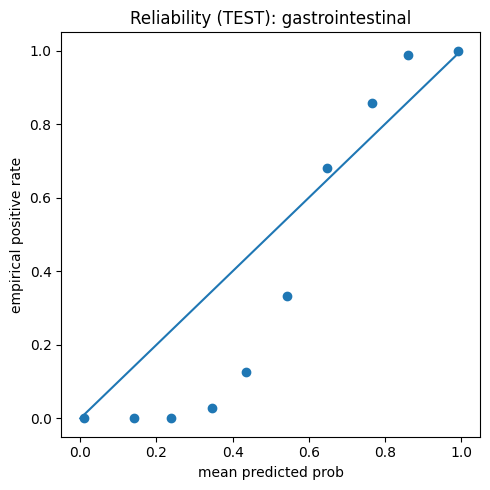

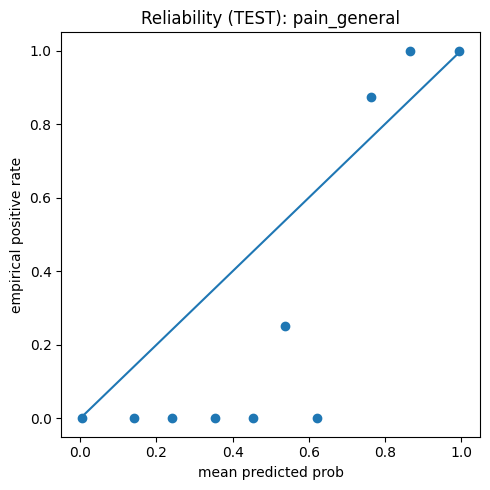

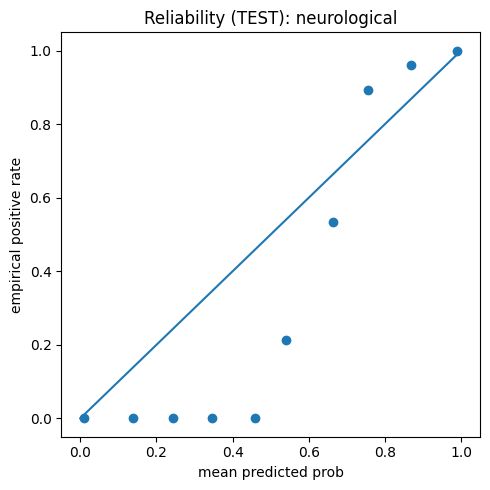

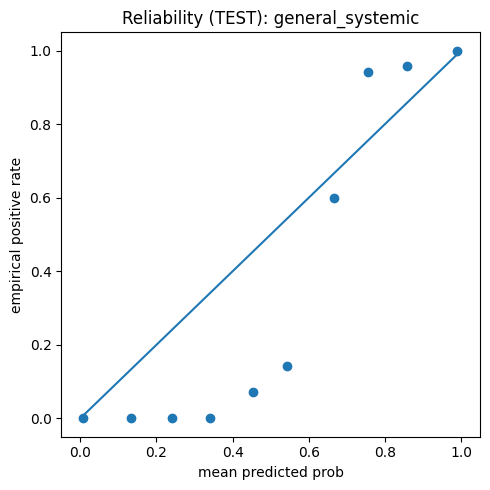

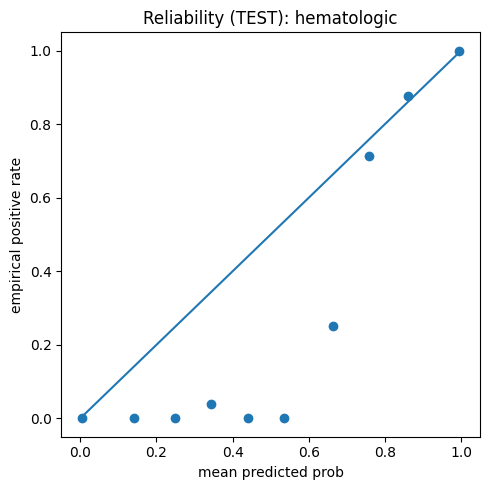

In [7]:
#CELL 7 — Calibration check (reliability) for top 6 labels (support katta)

#Bu “probability ishonchliligi”ni ko‘rsatadi.

def reliability_table(y_true, p_pred, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    ids = np.digitize(p_pred, bins) - 1
    ids = np.clip(ids, 0, n_bins-1)

    rows = []
    for b in range(n_bins):
        m = (ids == b)
        if m.sum() == 0:
            continue
        rows.append({
            "bin": b,
            "count": int(m.sum()),
            "p_mean": float(p_pred[m].mean()),
            "y_rate": float(y_true[m].mean()),
        })
    return pd.DataFrame(rows)

# eng ko'p supportli 6 label
top6 = per_label_df.sort_values("support", ascending=False).head(6)["label"].tolist()
name_list = [c.replace("y_","",1) for c in y_cols]
idxs = [name_list.index(x) for x in top6]

for idx in idxs:
    lab = name_list[idx]
    y = Yte[:, idx]
    p = Pte[:, idx]

    rt = reliability_table(y, p, n_bins=10)
    rt.to_csv(TABLES_OUT / f"reliability_{lab}.csv", index=False, encoding="utf-8-sig")

    plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1])
    plt.scatter(rt["p_mean"], rt["y_rate"])
    plt.title(f"Reliability (TEST): {lab}")
    plt.xlabel("mean predicted prob")
    plt.ylabel("empirical positive rate")
    plt.tight_layout()
    plt.savefig(VIS_OUT / f"reliability_{lab}.png", dpi=220, bbox_inches="tight")
    plt.show()

In [8]:
# CELL 8 — Interpretability: LogisticRegression top WORD features per label (saqlanadi)

# Sizning X = [char tfidf | word tfidf].
# Shuning uchun “word feature” koefflarini olish uchun offset = n_char.

tfidf_char = bundle["tfidf_char"]
tfidf_word = bundle["tfidf_word"]

feat_word = tfidf_word.get_feature_names_out()
n_char = len(tfidf_char.get_feature_names_out())

def top_word_features_for_label(label_idx, top_k=20):
    est = model.estimators_[label_idx]  # LogisticRegression
    w = est.coef_.ravel()
    w_word = w[n_char:]  # word part

    top_pos = np.argsort(w_word)[::-1][:top_k]
    top_neg = np.argsort(w_word)[:top_k]

    df_pos = pd.DataFrame({"label": name_list[label_idx], "direction": "pos", "term": feat_word[top_pos], "coef": w_word[top_pos]})
    df_neg = pd.DataFrame({"label": name_list[label_idx], "direction": "neg", "term": feat_word[top_neg], "coef": w_word[top_neg]})
    return pd.concat([df_pos, df_neg], axis=0, ignore_index=True)

# top supportli 6 label uchun featurelar
feat_rows = []
for idx in idxs:
    feat_rows.append(top_word_features_for_label(idx, top_k=25))

feat_df = pd.concat(feat_rows, axis=0, ignore_index=True)
display(feat_df.head(40))

feat_df.to_csv(TABLES_OUT / "top_word_features_top6labels.csv", index=False, encoding="utf-8-sig")

,label,direction,term,coef
0,dermatologic,pos,rash,22.155745
1,dermatologic,pos,pruritus,13.845172
2,dermatologic,pos,erythema,12.466111
3,dermatologic,pos,dry skin,12.109329
4,dermatologic,pos,dermatitis,11.767042
5,dermatologic,pos,acne,11.583528
6,dermatologic,pos,psoriasis,11.103552
7,dermatologic,pos,alopecia,10.981365
8,dermatologic,pos,blister,10.343532
9,dermatologic,pos,eczema,9.877843


,true_labels_per_row_mean,pred_labels_per_row_mean,true_labels_per_row_p95,pred_labels_per_row_p95
0,2.147368,2.152955,6.0,6.0


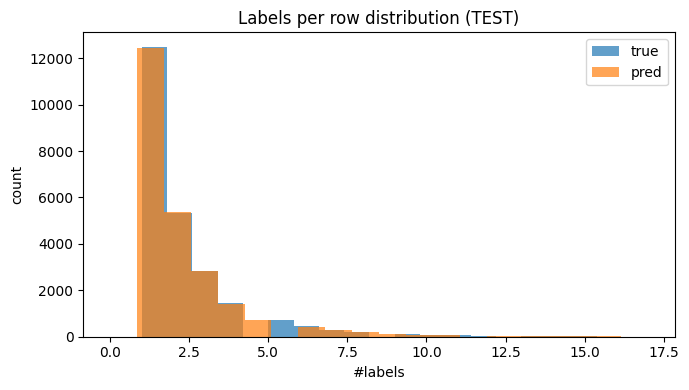

In [9]:
# CELL 9 — Advanced sanity: “prediction density” (necha label chiqyapti?)
true_cnt = Yte.sum(axis=1)
pred_cnt = Ypred.sum(axis=1)

summary = pd.DataFrame({
    "true_labels_per_row_mean": [float(true_cnt.mean())],
    "pred_labels_per_row_mean": [float(pred_cnt.mean())],
    "true_labels_per_row_p95":  [float(np.quantile(true_cnt, 0.95))],
    "pred_labels_per_row_p95":  [float(np.quantile(pred_cnt, 0.95))],
})
display(summary)
summary.to_csv(TABLES_OUT / "label_density_summary.csv", index=False, encoding="utf-8-sig")

plt.figure(figsize=(7,4))
plt.hist(true_cnt, bins=20, alpha=0.7, label="true")
plt.hist(pred_cnt, bins=20, alpha=0.7, label="pred")
plt.title("Labels per row distribution (TEST)")
plt.xlabel("#labels")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.savefig(VIS_OUT / "labels_per_row_true_vs_pred.png", dpi=220, bbox_inches="tight")
plt.show()

In [10]:
#CELL 10 — Final “advanced_eda summary” (bitta joyga jamlash)
final_summary = {
    "test_metrics": metrics,
    "num_rows_test": int(len(df_test)),
    "num_labels": int(len(y_cols)),
    "worst5_labels_by_f1": per_label_df.head(5)[["label","support","f1","precision","recall"]].to_dict(orient="records"),
    "best5_labels_by_f1": per_label_df.tail(5)[["label","support","f1","precision","recall"]].to_dict(orient="records"),
    "outputs": {
        "tables_out": str(TABLES_OUT),
        "visuals_out": str(VIS_OUT),
    }
}
(TABLES_OUT / "advanced_eda_summary.json").write_text(json.dumps(final_summary, indent=2, ensure_ascii=False), encoding="utf-8")
print("Saved:", TABLES_OUT / "advanced_eda_summary.json")

Saved: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\results\tables\advanced_eda_outputs\advanced_eda_summary.json


In [11]:
# bizning holatimizda bu advanced EDA nimani beradi?

# Agar F1 juda yuqori bo‘lsa ham, qaysi labellar eng ko‘p xato qilayotganini ko‘rsatadi.

# FP/FN misollar orqali mapping/regex yoki preprocessing’da nima “shovqin” ekanini ko‘ramiz.

# Reliability plot’lar orqali proba ishonchlilikni ko‘ramiz (keyin triage uchun muhim).

# Word featurelar orqali “model nima ko‘rib qaror qildi?” deb isbotlab beramiz.